## Size Distribution Merge Lab

### Read arcsix data using ict_utils.py

In [1]:
import sys
from pathlib import Path
BASE_DIR = Path.cwd().parent
sys.path.append(str(BASE_DIR / "dev"))
import numpy as np
import pandas as pd

from ict_utils import (read_aps, read_nmass, read_pops, read_uhsas, read_fims, read_inlet_flag,
    check_common_grid, filter_by_spectra_presence, mean_spectrum,)
from sizedist_utils import (edges_from_mids_geometric, dvdlog_from_dndlog, 
    dsdlog_from_dndlog, mids_from_edges, remap_dndlog_by_edges, select_between)

# ============================ CONFIG ============================
start = "2024-06-11 16:00"                                              # Change this
end   = "2024-06-11 16:10"                                              # Change this
d_str = pd.to_datetime(start).date().isoformat()

DATA_DIR = Path("/Volumes/Hailstone Data/Research Data/ARCSIX_P3B")     # Change this

aps_dir   = DATA_DIR / "LARGE-APS"
nmass_dir = DATA_DIR / "PUTLS-NMASS"
pops_dir  = DATA_DIR / "PUTLS-POPS"
uhsas_dir = DATA_DIR / "PUTLS-UHSAS"
fims_dir  = DATA_DIR / "FIMS"
inlet_dir = DATA_DIR / "LARGE-InletFlag"

OPC_RESPONSE_BINS = 50        # Controls the smoothness of the OPC response functions


# ---------- helpers ----------
def edges_from_meta_or_mids(df: pd.DataFrame, mids_nm: np.ndarray) -> np.ndarray:
    meta = (df.attrs.get("bin_meta") or {})
    lo = meta.get("lower_nm")
    up = meta.get("upper_nm")
    if isinstance(lo, (list, tuple)) and isinstance(up, (list, tuple)) and len(lo) == len(up) and len(lo) > 0:
        return np.r_[np.asarray(lo, float), float(up[-1])]
    return edges_from_mids_geometric(mids_nm)

# ---------- read ----------
aps        = read_aps       (aps_dir,   start=start, end=end, prefix="ARCSIX")
nmass      = read_nmass     (nmass_dir, start=start, end=end, prefix="ARCSIX")
pops       = read_pops      (pops_dir,  start=start, end=end, prefix="ARCSIX")
uhsas      = read_uhsas     (uhsas_dir, start=start, end=end, prefix="ARCSIX")
fims       = read_fims      (fims_dir,  start=start, end=end, prefix="ARCSIX")
inlet_flag = read_inlet_flag(inlet_dir, start=start, end=end, prefix="ARCSIX")

frames = {"APS": aps, "POPS": pops, "UHSAS": uhsas, "FIMS": fims}
_ = check_common_grid(frames, ref_key="FIMS", round_to=None)

# ---------- optional presence filter ----------
fims_qc = pd.to_numeric(fims.get("QC_Flag", pd.Series(index=fims.index)), errors="coerce")
extra = {"FIMS": fims_qc.ne(2)}  # bad=2
filtered, _keep = filter_by_spectra_presence(
    frames, col_prefix="dNdlogDp",
    min_instruments=None,
    extra_masks=extra, treat_nonpositive_as_nan=False
)

# ---------- mean spectra + edges ----------
m_APS,   y_APS,   s_APS,   _ = mean_spectrum(aps,   "APS")
e_APS   = edges_from_meta_or_mids(aps,   m_APS)

m_POPS,  y_POPS,  s_POPS,  _ = mean_spectrum(pops,  "POPS")
e_POPS  = edges_from_meta_or_mids(pops,  m_POPS)

m_UHSAS, y_UHSAS, s_UHSAS, _ = mean_spectrum(uhsas, "UHSAS")
e_UHSAS = edges_from_meta_or_mids(uhsas, m_UHSAS)

m_FIMS,  y_FIMS,  s_FIMS,  _ = mean_spectrum(fims,  "FIMS")
e_FIMS = edges_from_meta_or_mids(fims,  m_FIMS)



In [2]:
# ---------- pack into specs ----------
specs = {
    "APS":   (m_APS,   e_APS,   y_APS,   s_APS),
    #"POPS":  (m_POPS,  e_POPS,  y_POPS,  s_POPS),
    "UHSAS": (m_UHSAS, e_UHSAS, y_UHSAS, s_UHSAS),
    "FIMS":  (m_FIMS,  e_FIMS,  y_FIMS,  s_FIMS),
}

line_kwargs = {
    "_default": {"linewidth": 1.5, 'color':'k'},
    "APS":   {"color":"tab:blue", "alpha":0.6, 'ls':'dashed'},
    #"POPS":  {"color":"tab:orange"},
    "UHSAS": {"color":"tab:green", "alpha":0.6, 'ls':'dashed'},
    "FIMS":  {"color":"tab:red"},
}

fill_kwargs = {
    "_default": {"alpha": 0.1, 'color':'k'},
    #"APS":   {"alpha":0.1,"color":"tab:blue"},
    "APS": False,  # disable fill for APS
    #"POPS":  {"alpha":0.1,"color":"tab:orange"},
    #"UHSAS": {"alpha":0.1,"color":"tab:green"},
    "UHSAS": False,
    "FIMS":  {"alpha":0.1,"color":"tab:red"},
}

### Convert APS Sizes

In [9]:
from diameter_conversion_core import da_to_dv

rho_p_APS = 900
chi_t_APS = 1
e_APS_dv = da_to_dv(e_APS, rho_p_APS, chi_t=chi_t_APS, rho0=1000.0)
m_APS_dv = mids_from_edges(e_APS_dv)
y_APS_dv = remap_dndlog_by_edges(e_APS, e_APS_dv, y_APS)
s_APS_dv = remap_dndlog_by_edges(e_APS, e_APS_dv, s_APS)

label_aps_dv = f'APS \u03C1={rho_p_APS}'
specs[label_aps_dv] = (m_APS_dv, e_APS_dv, y_APS_dv, s_APS_dv)

line_kwargs[label_aps_dv] = {"color":"tab:blue"}
fill_kwargs[label_aps_dv] = {"alpha":0.1,"color":"tab:blue"}


### Convert UHSAS sizes

In [8]:
from optical_diameter_core import SigmaLUT, convert_do_lut, RI_UHSAS_SRC

BASE_DIR = Path.cwd().parent
lut_uhsas = SigmaLUT(str(BASE_DIR / "lut" / "uhsas_sigma_col_1054nm.zarr"))

ri_uhsas = complex(1.65, 0.001)
e_uhsas_newdo = convert_do_lut(e_UHSAS, ri_src=RI_UHSAS_SRC, ri_dst=ri_uhsas, lut=lut_uhsas, response_bins=OPC_RESPONSE_BINS)
m_uhsas_newdo = mids_from_edges(e_uhsas_newdo)
y_uhsas_newdo = remap_dndlog_by_edges(e_UHSAS, e_uhsas_newdo, y_UHSAS)
s_uhsas_newdo = remap_dndlog_by_edges(e_UHSAS, e_uhsas_newdo, s_UHSAS)

specs[f'UHSAS RI={ri_uhsas}'] = (m_uhsas_newdo, e_uhsas_newdo, y_uhsas_newdo, s_uhsas_newdo)


### Match uhsas with fims

In [ ]:
# === Optimize UHSAS (n,k) to match FIMS, then remap UHSAS and add to specs ===
import matplotlib.pyplot as plt
from sizedist_alignment import optimize_refractive_index_for_opc
from optical_diameter_core import SigmaLUT, convert_do_lut, RI_UHSAS_SRC

# LUT and source RI for UHSAS
BASE_DIR = Path.cwd().parent
lut_uhsas = SigmaLUT(str(BASE_DIR / "lut" / "uhsas_sigma_col_1054nm.zarr"))

# Optimize (n,k): target = FIMS (reference), source = UHSAS (to be remapped)
n_best, k_best, best_cost, res, uhs_hist = optimize_refractive_index_for_opc(
    x_ref=m_FIMS,            # reference mids [nm]
    y_ref=y_FIMS,            # reference dN/dlog10D
    edges_DRV=e_UHSAS,       # UHSAS edges [nm]
    y_DRV=y_UHSAS,           # UHSAS dN/dlog10D
    m_src=RI_UHSAS_SRC,      # UHSAS assumed source RI in the LUT
    lut=lut_uhsas,
    response_bins=OPC_RESPONSE_BINS,       # For UHSAS response function you can tweak
    moment="V",              # compare number-weighted
    space="linear",          # log-space MSE tends to be robust
    bounds=((1.3, 1.8), (0.0, 0.001)),
    maxiter=200,
    tol=1e-6,
    seed=123,
)

ri_fit = complex(n_best, k_best)

# Remap UHSAS edges to the fitted RI and conserve counts
e_UHSAS_fit = convert_do_lut(
    Do_nm=e_UHSAS,
    ri_src=RI_UHSAS_SRC,
    ri_dst=ri_fit,
    lut=lut_uhsas,
    response_bins=OPC_RESPONSE_BINS,
)
m_UHSAS_fit = mids_from_edges(e_UHSAS_fit)
y_UHSAS_fit = remap_dndlog_by_edges(e_UHSAS, e_UHSAS_fit, y_UHSAS)
s_UHSAS_fit = remap_dndlog_by_edges(e_UHSAS, e_UHSAS_fit, s_UHSAS)

# Add optimized UHSAS to specs
label_uhsas_fit = f"UHSAS fit→FIMS (n={n_best:.3f}, k={k_best:.3f})"
specs[label_uhsas_fit] = (m_UHSAS_fit, e_UHSAS_fit, y_UHSAS_fit, s_UHSAS_fit)

# plot settings
line_kwargs[label_uhsas_fit] = {"color": "tab:green", "linewidth": 2.0}
fill_kwargs[label_uhsas_fit] = {"alpha": 0.10, "color": "tab:green"}

print(f"[UHSAS→FIMS] best n={n_best:.4f}, k={k_best:.4f}, cost={best_cost:.4g}")

# ---- loss histories ----
fig_hist_u, ax_hist_u = plt.subplots(1, 1, figsize=(6, 4))
iter_u = np.arange(1, len(uhs_hist["total"])+1, dtype=int)
ax_hist_u.plot(iter_u, uhs_hist["total"], label="UHSAS total", linewidth=2, color='k')
ax_hist_u.set_xlabel("DE iteration"); ax_hist_u.set_ylabel("MSE")
ax_hist_u.set_title("UHSAS refractive index optimization history")
ax_hist_u.grid(True, which="both", linestyle=":", linewidth=0.6); ax_hist_u.legend()
plt.tight_layout()

### Match uhsas, aps, and fims (reference) at the same time

[UHSAS] n=1.6335
[APS]   rho_p=1140.8 kg/m^3
[Cost]  0.089405


/Users/C832577250/miniforge3/envs/Research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
/Users/C832577250/miniforge3/envs/Research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


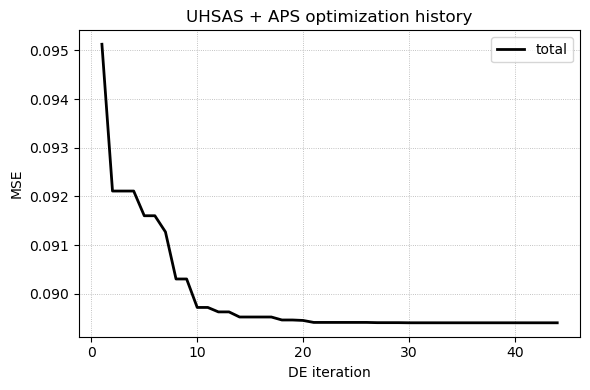

In [3]:
# === Joint optimization: UHSAS (n,k) and APS (rho_p) vs FIMS ===
import matplotlib.pyplot as plt
from sizedist_alignment import optimize_multi_custom
from optical_diameter_core import SigmaLUT, convert_do_lut, RI_UHSAS_SRC
from diameter_conversion_core import da_to_dv
from sizedist_utils import remap_dndlog_by_edges, mids_from_edges, select_between

# ---------------- user knobs ----------------
MOMENT = "V"           # "N", "S", or "V"   (used inside MSE)
SPACE  = "linear"      # "linear" or "log"
PAIR_W = 1.0           # cross-consistency weight between UHSAS and APS (set 0 to disable)

# bounds
BOUNDS_UHSAS = [(1.3, 1.8)]               # (n); k is fixed to 0
BOUNDS_APS   = [(600.0, 2000.0)]          # (rho_p) only; chi_t fixed to 1.0

UHSAS_XMIN = 250
UHSAS_XMAX = None

FIMS_XMIN = None
FIMS_XMAX = None

# LUT for UHSAS optical response
BASE_DIR = Path.cwd().parent
lut_uhsas = SigmaLUT(str(BASE_DIR / "lut" / "uhsas_sigma_col_1054nm.zarr"))

# ---------------- remap functions (edges, theta, **kwargs) -> new_edges ----------------
def uhsas_remap_fn(edges, theta, *, lut, ri_src, k = 0, response_bins=50):
    n = float(theta[0])      # real part of refractive index is optimized
    return convert_do_lut(
        Do_nm=edges,
        ri_src=ri_src,
        ri_dst=complex(n, k),
        lut=lut,
        response_bins=response_bins,
    )

def aps_remap_fn(edges, theta, *, chi_t=1.0, rho0=1000.0, pres_hPa=1013.25, temp_C=20.0):
    rho_p = float(theta[0])  # only density is optimized
    return da_to_dv(
        edges,
        rho_p=rho_p,
        chi_t=float(chi_t),
        rho0=float(rho0),
        pres_hPa=float(pres_hPa),
        temp_C=float(temp_C),
    )

m_uhsas_sel, e_uhsas_sel, y_uhsas_sel, s_uhsas_sel \
    = select_between(m_UHSAS, e_UHSAS, y_UHSAS, s_UHSAS, xmin = UHSAS_XMIN, xmax = UHSAS_XMAX)

m_fims_sel, e_fims_sel, y_fims_sel, s_fims_sel \
    = select_between(m_FIMS,  e_FIMS,  y_FIMS,  s_FIMS,  xmin = FIMS_XMIN, xmax = FIMS_XMAX)


# ---------------- assemble instrument configs ----------------
instruments = [
    {
        "edges":   e_uhsas_sel,                # original UHSAS edges (nm)
        "y":       y_uhsas_sel,                # original dN/dlog10D on those edges
        "remap_fn": uhsas_remap_fn,
        "kwargs":  {"lut": lut_uhsas, "ri_src": RI_UHSAS_SRC, "response_bins": 50},
        "w_ref":   1.0,                    # weight vs FIMS
    },
    {
        "edges":   e_APS,                  # original APS edges (nm)
        "y":       y_APS,                  # original dN/dlog10D on those edges
        "remap_fn": aps_remap_fn,
        "kwargs":  {"chi_t": 1.0, "rho0": 1000.0, "pres_hPa": 1013.25, "temp_C": 20.0},
        "w_ref":   1.0,                    # weight vs FIMS
    },
]
bounds_list = [BOUNDS_UHSAS, BOUNDS_APS]

# Optional cross-instrument term: encourage UHSAS and APS to agree after remap
pair_weights = [(0, 1, PAIR_W)] if PAIR_W != 0 else None

# ---------------- run optimization ----------------
best_thetas, best_cost, res, hist = optimize_multi_custom(
    ref_mids=m_fims_sel,        # FIMS mids (nm)
    ref_y=y_fims_sel,           # FIMS dN/dlog10D
    instruments=instruments,
    bounds_list=bounds_list,
    moment=MOMENT,
    space=SPACE,
    pair_weights=pair_weights,
    maxiter=200,
    tol=1e-6,
    seed=123
)

theta_uhsas, theta_aps = best_thetas
n_fit       = float(theta_uhsas[0])
rho_fit     = float(theta_aps[0])

print(f"[UHSAS] n={n_fit:.4f}")
print(f"[APS]   rho_p={rho_fit:.1f} kg/m^3")
print(f"[Cost]  {best_cost:.6g}")

# ---------------- apply remaps with fitted params ----------------
e_UHSAS_fit = uhsas_remap_fn(e_uhsas_sel, [n_fit], lut=lut_uhsas, ri_src=RI_UHSAS_SRC, response_bins=120)
m_UHSAS_fit = mids_from_edges(e_UHSAS_fit)
y_UHSAS_fit = remap_dndlog_by_edges(e_uhsas_sel, e_UHSAS_fit, y_uhsas_sel)
s_UHSAS_fit = remap_dndlog_by_edges(e_uhsas_sel, e_UHSAS_fit, s_uhsas_sel)

e_APS_fit = aps_remap_fn(e_APS, [rho_fit], chi_t=1.0, rho0=1000.0, pres_hPa=1013.25, temp_C=20.0)
m_APS_fit = mids_from_edges(e_APS_fit)
y_APS_fit = remap_dndlog_by_edges(e_APS, e_APS_fit, y_APS)
s_APS_fit = remap_dndlog_by_edges(e_APS, e_APS_fit, s_APS)

# ---------------- (optional) add to specs for plotting ----------------
optimized_uhsas_label = f"UHSAS fit→FIMS (n={n_fit:.3f})"
specs[optimized_uhsas_label] = (m_UHSAS_fit, e_UHSAS_fit, y_UHSAS_fit, s_UHSAS_fit)

# plot settings
line_kwargs[optimized_uhsas_label] = {"color": "tab:green", "linewidth": 2.0}
fill_kwargs[optimized_uhsas_label] = {"alpha": 0.10, "color": "tab:green"}

optimized_aps_label = f"APS fit→FIMS (ρ={rho_fit*0.001:.3f} g/cm$^3$)"
specs[optimized_aps_label] = (m_APS_fit,   e_APS_fit,   y_APS_fit,   s_APS_fit)

# plot settings
line_kwargs[optimized_aps_label] = {"color": "tab:blue", "linewidth": 2.0}
fill_kwargs[optimized_aps_label] = {"alpha": 0.10, "color": "tab:blue"}

# ---- loss histories ----
fig_hist_u, ax_hist_u = plt.subplots(1, 1, figsize=(6, 4))
iter_u = np.arange(1, len(hist["total"])+1, dtype=int)
ax_hist_u.plot(iter_u, hist["total"], label="total", linewidth=2, color='k')
ax_hist_u.set_xlabel("DE iteration"); ax_hist_u.set_ylabel("MSE")
ax_hist_u.set_title("UHSAS + APS optimization history")
ax_hist_u.grid(True, which="both", linestyle=":", linewidth=0.6); ax_hist_u.legend()
plt.tight_layout()


### Leastsquare with Tikhonov regularization rebin

In [ ]:
from sizedist_combine import make_grid_from_series, merge_sizedists_tikhonov
from sizedist_utils import mids_from_edges

# --- IMPORTANT: this code expects x = mids (NOT edges) ---
# If you currently have edges-only, convert first:
m_FIMS   = mids_from_edges(e_fims_sel)
m_UHSASf = mids_from_edges(e_UHSAS_fit)
m_APSf   = mids_from_edges(e_APS_fit)

# Build series list (NO sigma passed)
series = [
    {"x": m_FIMS,   "y": y_fims_sel,   "alpha": 1.0},
    {"x": m_UHSASf, "y": y_UHSAS_fit,  "alpha": 1.0},
    {"x": m_APSf,   "y": y_APS_fit,    "alpha": 1.0},
]

TOKHONOV_LAM = 1e-5

# Common log grid from union of mids (still mids)
Dg = make_grid_from_series(series, n_points="auto")  # returns mids grid (nm)

# Merge on that grid with Tikhonov smoothing (nonneg enforced)
y_merged, wsum, diag = merge_sizedists_tikhonov(
    Dg, series, lam=TOKHONOV_LAM, eps=1e-12, nonneg=True
)

Dg_edge = edges_from_mids_geometric(Dg)

# Add to specs for plotting (your plotting expects mids + edges;
# here we only have mids, so just stash edges=None or reuse a cosmetic edge array if your plotter needs it)
specs_label = "Tikhonov regularization"

merged_spec = {}; merged_line_kwargs = {}; merged_fill_kwargs = {}

merged_spec[specs_label] = (Dg, Dg_edge, y_merged, np.full_like(Dg, np.nan))
merged_line_kwargs[specs_label] = {"color": "gray", "linewidth": 2.2}
merged_fill_kwargs[specs_label] = False

### Twomey inversion rebin

In [5]:
import numpy as np
from sizedist_utils import mids_from_edges, edges_from_mids_geometric
from forward_kernel import K_tophat, apply_kernel_counts
from twomey_inversion import twomey_inversion

# ---------- helper: bin widths in log10 space ----------
def _dlog10(E_nm):
    E_nm = np.asarray(E_nm, float)
    return np.diff(np.log10(E_nm))

# ---------- BUILD FINE GRID ----------
series = [
    {"x": m_FIMS,   "y": y_fims_sel,   "alpha": 1.0},
    {"x": m_UHSASf, "y": y_UHSAS_fit,  "alpha": 1.0},
    {"x": m_APSf,   "y": y_APS_fit,    "alpha": 1.0},
]

E_fine = make_grid_from_series(series, n_points="auto")  # returns mids grid (nm)
M_fine = mids_from_edges(E_fine)

# ---------- FORWARD KERNELS (top-hat overlap in log10 Dp) ----------
K_fims   = K_tophat(np.log10(E_fine), np.log10(e_fims_sel))
K_uhsas  = K_tophat(np.log10(E_fine), np.log10(e_UHSAS_fit))
K_aps    = K_tophat(np.log10(E_fine), np.log10(e_APS_fit))

# ---------- OBSERVED COUNTS per instrument bin (number-conserving) ----------
# y (dN/dlogDp) × Δlog10D → N (counts in each bin)
dlog_fims  = _dlog10(e_fims_sel)
dlog_uhsas = _dlog10(e_UHSAS_fit)
dlog_aps   = _dlog10(e_APS_fit)

N_fims  = y_fims_sel  * dlog_fims
N_uhsas = y_UHSAS_fit * dlog_uhsas
N_aps   = y_APS_fit   * dlog_aps

# ---------- CLEAN INVALID ROWS (strictly minimal) ----------
# Keep bins with finite y and positive, finite Δlog10D; drop rows in K accordingly.
m_fims  = np.isfinite(N_fims)  & np.isfinite(dlog_fims)  & (dlog_fims  > 0)
m_uhsas = np.isfinite(N_uhsas) & np.isfinite(dlog_uhsas) & (dlog_uhsas > 0)
m_aps   = np.isfinite(N_aps)   & np.isfinite(dlog_aps)   & (dlog_aps   > 0)

K_fims   = K_fims[m_fims, :]
K_uhsas  = K_uhsas[m_uhsas, :]
K_aps    = K_aps[m_aps, :]

N_fims   = np.clip(N_fims[m_fims], 0.0, None)
N_uhsas  = np.clip(N_uhsas[m_uhsas], 0.0, None)
N_aps    = np.clip(N_aps[m_aps], 0.0, None)

# (Optional) per-bin data weights; here use uniform but scale by alpha if you have them
alpha_fims  = 1.0
alpha_uhsas = 1.0
alpha_aps   = 1.0
w_fims  = np.full_like(N_fims,  alpha_fims,  dtype=float)
w_uhsas = np.full_like(N_uhsas, alpha_uhsas, dtype=float)
w_aps   = np.full_like(N_aps,   alpha_aps,   dtype=float)

# ---------- STACKED SYSTEM: y ≈ K n  ----------
K_stack = np.vstack([K_fims, K_uhsas, K_aps])           # (m_total, n_fine)
y_stack = np.concatenate([N_fims, N_uhsas, N_aps])      # (m_total,)
w_stack = np.concatenate([w_fims, w_uhsas, w_aps])      # (m_total,)

# ---------- TWOMEY INVERSION (nonnegative, smooth) ----------
TWOMEY_LAM   = 1e-3   # ↑ smoother, ↓ sharper (typical 1e-4 … 1e-2)
TWOMEY_ORDER = 2      # curvature penalty; 1 = slope, 0 = zeroth-order
n_fine, info = twomey_inversion(
    K_stack, y_stack, lam=TWOMEY_LAM, order=TWOMEY_ORDER, w=w_stack, nonneg=True
)
# n_fine is dN/dlog10D on E_fine mids

# ---------- MERGED OUTPUT FOR PLOTTING ----------
Dg       = M_fine
Dg_edge  = E_fine
y_merged = n_fine
specs_label = "Twomey inversion"

specs[specs_label] = (Dg, Dg_edge, y_merged, np.full_like(Dg, np.nan))

# plot settings
line_kwargs[specs_label] = {"color": "k", "linewidth": 2.2}
fill_kwargs[specs_label] = False


print(f"[Twomey] method={info.get('method')}  res_norm={info.get('res_norm', np.nan):.3g}  "
      f"n_fine={Dg.size}, bins={Dg_edge.size-1}")

[Twomey] method=nnls  res_norm=1.22  n_fine=89, bins=89


### Plot all size distribution in specs

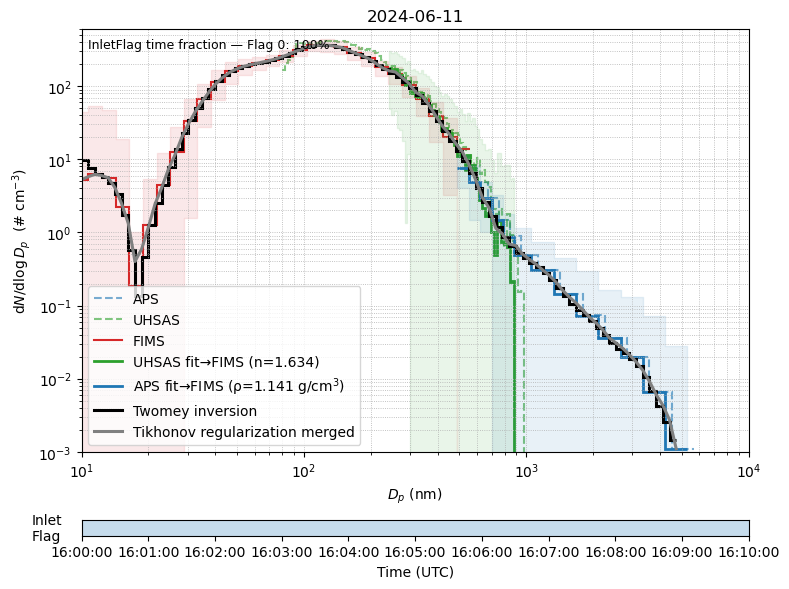

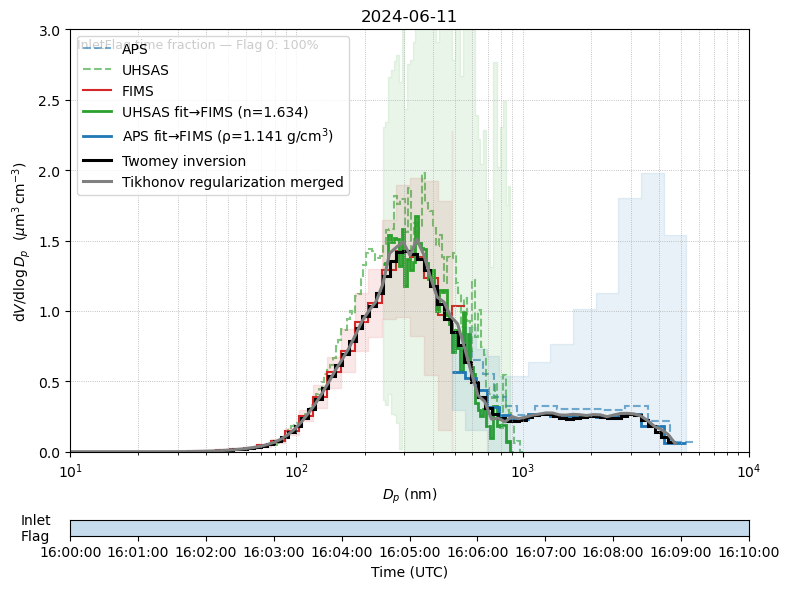

In [6]:
import matplotlib.pyplot as plt
from sizedist_plot import plot_size_distributions, plot_size_distributions_steps

# ============================ PLOT CALL ============================


# --- plot step-style ---
fig, (ax, axf), handles = plot_size_distributions_steps(
    specs=specs,
    inlet_flag=inlet_flag,
    yscale="log",          # or "log"
    xlim=(10, 1e4),
    ylim=(1E-3, 6E2),          
    line_kwargs=line_kwargs,
    fill_kwargs=fill_kwargs,
    show_flag_strip=True,
    moment = 'N',
)

plot_size_distributions(
    specs=merged_spec,
    inlet_flag=inlet_flag,
    yscale="log",          # or "log"
    xlim=(10, 1e4),
    ylim=(1E-3, 6E2),          
    line_kwargs=merged_line_kwargs,
    fill_kwargs=merged_fill_kwargs,
    show_flag_strip=False,
    moment = 'N',
    fig = fig,
    ax = ax
)

ax.set_title(f'{d_str}')
# convert your specs (which are in dN/dlogDp) to dV/dlogDp
specs_V = {
    lab: (mids, edges,
          dvdlog_from_dndlog(mids, vals),
          dvdlog_from_dndlog(mids, sigma))
    for lab, (mids, edges, vals, sigma) in specs.items()
}

merged_spec_V = {
    lab: (mids, edges,
          dvdlog_from_dndlog(mids, vals),
          dvdlog_from_dndlog(mids, sigma))
    for lab, (mids, edges, vals, sigma) in merged_spec.items()
}

# then plot the volume distribution
fig, (ax, axf), handles = plot_size_distributions_steps(
    specs=specs_V,
    inlet_flag=inlet_flag,
    yscale="linear",
    xlim=(10, 1e4),
    ylim=(None, 3),
    line_kwargs=line_kwargs,
    fill_kwargs=fill_kwargs,
    show_flag_strip=True,
    moment = 'V',
)

plot_size_distributions(
    specs=merged_spec_V,
    inlet_flag=inlet_flag,
    yscale="linear",
    xlim=(10, 1e4),
    ylim=(None, 3),
    line_kwargs=merged_line_kwargs,
    fill_kwargs=merged_fill_kwargs,
    show_flag_strip=False,
    moment = 'V',
    fig = fig,
    ax = ax
)

ax.set_title(f'{d_str}')

plt.show()